In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

## Input of PIV results, red beads masks and aggregate images

In [2]:
# open .h5 file containing piv results.
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/test_piv/red_beads_matrix"
with h5py.File(h5_file_path, "r") as h5f:
    U = h5f["U"][:] # shape: frame, rows, columns 
    V = h5f["V"][:]
    M = h5f["M"][:]
    xgrid = h5f["xgrid"][:]
    ygrid = h5f["ygrid"][:]

In [3]:
# open .h5 file of masked red beads images.
red_beads_file_path = "F:/PhD_Franziska/Headon/RedBeads/mask_red_beads_cut1.h5"
with h5py.File(red_beads_file_path, "r") as h5f:
    red_beads = h5f["masked_red_beads"][:]

In [4]:
# open .h5 file for aggregate images.
aggregate_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1(2).h5"
with h5py.File(aggregate_file_path, "r") as h5f:
    aggregate = h5f["green"][:]

In [5]:
sub_frame = red_beads[99:130]
sub_frame_aggregate = aggregate[99:130]
sub_frame.shape

(31, 900, 800)

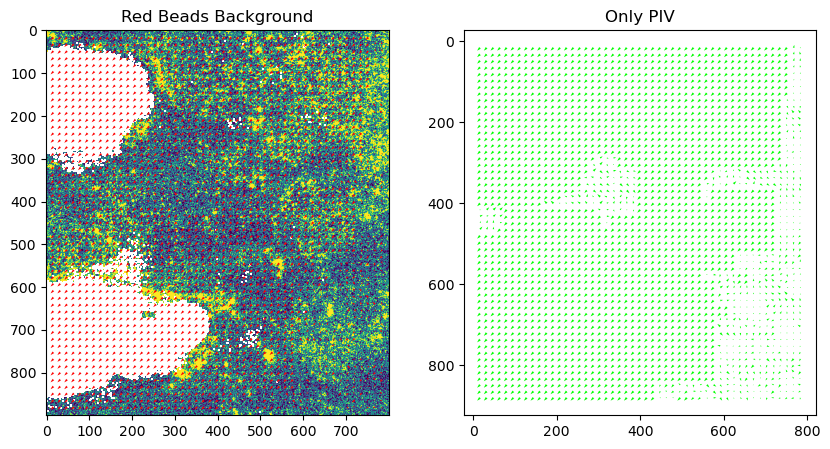

In [6]:
t = 0

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Red Beads Background")
# plt.imshow(sub_frame_aggregate[t])
plt.imshow(sub_frame[t])
plt.quiver(ygrid[t], xgrid[t], U[t], V[t], color = "red")

plt.subplot(1, 2, 2)
plt.title("Only PIV")
plt.quiver(ygrid[t], xgrid[t], U[t], V[t], color = "lime")
plt.gca().invert_yaxis()
plt.show()

## Cut the regions that are not covered by skin tissue. Those are NaN in red beads masks. 

In [7]:
xgrid[0][0].astype(np.uint8)

array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
      dtype=uint8)

In [8]:
ygrid[0]

array([[ 16.,  32.,  48., ..., 752., 768., 784.],
       [ 16.,  32.,  48., ..., 752., 768., 784.],
       [ 16.,  32.,  48., ..., 752., 768., 784.],
       ...,
       [ 16.,  32.,  48., ..., 752., 768., 784.],
       [ 16.,  32.,  48., ..., 752., 768., 784.],
       [ 16.,  32.,  48., ..., 752., 768., 784.]], dtype=float32)

In [9]:
matrix = np.array([[1, np.nan, 3], [4, 5, np.nan], [7, 8, 9]])  # matrix with NaN values
index_matrix1 = np.array([0, 1, 2])  # row indices
index_matrix2 = np.array([1, 2, 0])  # column indices

# Get the corresponding values from the matrix using the indices
corresponding_values = matrix[index_matrix1, index_matrix2]

# Check if the corresponding values are NaN
is_nan = np.isnan(corresponding_values)

nan_indices = np.where(is_nan)[0]

print(nan_indices)

[0 1]


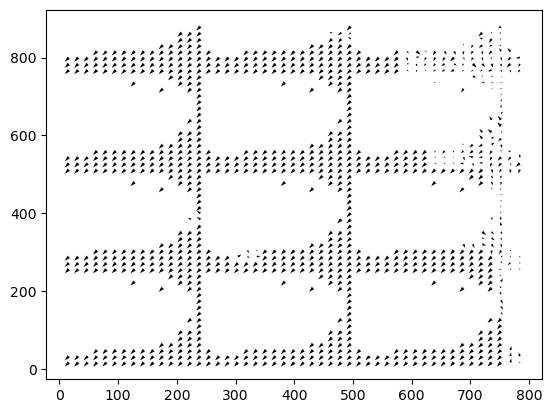

In [7]:
# Alternative 1: Use index from grid matrix, check if the correspoding position has in red beads mask value NaN.
# If the value is NaN, then find out the index of this position in grid matrices. 
# Then set the vector values with this index to NaN. 

# TODO: --> Bug contained!

# xgrid_matrix = xgrid[0]
# ygrid_matrix = ygrid[0]
# red_bead_mask = sub_frame[0]
# U_matrix = U[0]
# V_matrix = V[0]

# # Find out the index for position from grid matrix which corresponds to NaN in masks. 
# for i in range(xgrid_matrix.shape[0]):
#     mask_value = red_bead_mask[xgrid_matrix[i,:].astype(np.uint8), ygrid_matrix[i,:].astype(np.uint8)]
#     is_nan = np.isnan(mask_value)
#     col_index = np.where(is_nan)
#     row_index = np.full(len(col_index), i)

# # Change the vector value with those index to NaN. 
#     U_matrix[row_index, col_index] = np.nan
#     V_matrix[row_index, col_index] = np.nan

# # Plot the cutted vector field.
# plt.quiver(ygrid_matrix, xgrid_matrix, U_matrix, V_matrix)

In [14]:
mask_value

array([ 1.,  1.,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0.,  1.,  1.,  0., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  0.,  1.,  1.,  0., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan,  0.,  1.])

## Bug tracking: Only do the nan deletion for one line!

In [24]:
ygrid_matrix[10].astype(np.uint8)
ygrid_matrix[10, :]
#red_bead_mask[xgrid_matrix[10,:].astype(np.uint8), ygrid_matrix[10,:].astype(np.uint8)]
# ygrid_matrix[0,:]
# xgrid_matrix[0,:]
#red_bead_mask[176, :]

# E.g. the data on row 176 doesn't match!

array([ 16.,  32.,  48.,  64.,  80.,  96., 112., 128., 144., 160., 176.,
       192., 208., 224., 240., 256., 272., 288., 304., 320., 336., 352.,
       368., 384., 400., 416., 432., 448., 464., 480., 496., 512., 528.,
       544., 560., 576., 592., 608., 624., 640., 656., 672., 688., 704.,
       720., 736., 752., 768., 784.], dtype=float32)

In [95]:
nan_index = np.where(np.isnan(red_bead_mask))
row_index, col_index = nan_index[0], nan_index[1]
red_bead_mask[row_index[0], col_index[0]]

nan

In [19]:
np.where(np.isnan(red_bead_mask))

(array([  9,  13,  16, ..., 882, 890, 892], dtype=int64),
 array([585, 581, 597, ...,  35,   4, 498], dtype=int64))

In [83]:
# Alternative 2: Get all index of NaN in mask. Find if the index appears in grid matrix.
# If appears, find out the position in grid matrices.
# Set the vector values with those positions to NaN. 

# xgrid_matrix = xgrid[0]
# ygrid_matrix = ygrid[0]
# red_bead_mask = sub_frame[0]
# U_matrix = U[0]
# V_matrix = V[0]

# # Find out the positions of NaN in red bead mask 
